 # <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.5em;color:#00b3e5;">  Project in Recommendation System

<a id='Imports'></a>

## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.5em;color:#00b3e5;">  Import all required modules

In [259]:
%matplotlib inline

#from colorama import init, Fore, Back, Style
import math as math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown

## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.2em;color:#00b3e5;"> Global Constants and Required common functions

In [260]:
# Helper common function used every where in the below code to
# print dataframe details. This function will accept only DataFrame
# type. Otherwise it throws Exception
def print_df_details(df):
    if isinstance(df, pd.DataFrame):
        print("\n****** Start Dataframe Details ******")
        print("Dataframe Shape is ")
        print(df.shape)
        print("Dataframe Info is ")
        print(df.info())
        print("Dataframe random records ")
        display(df.sample(5) if len(df) > 5 else df.sample(1))
        print("****** End Dataframe Details ******\n")
    else:
        raise UnsupportedType('Unsupported type to print ', type(df))


In [261]:
# It prints given value and text with markdown
def print_inference(value, txt):
    if (txt == None):
        display(Markdown(f"#### [{value}]"))
    elif (type(value) == str):
        display(Markdown(f"#### [{value}] {txt}"))
    elif (isinstance(value, list) == True):
        display(Markdown(f"#### {value} [{len(value)}] {txt}"))
    else:
        display(Markdown(f"#### {value} {txt}"))

In [262]:
# Read given file and convert it to Dataframe.
# We use option to skipinitialspace as True so that we can automatically 
# get rid of those spaces after delimitor in the resulting data frame
def file_to_df(fqfn, file_type='csv'):
    df = 'None'
    # We are only handling csv files. How about .dat
    # We are also using "skipinitialspace" parameter so that we 
    # can save some time in preprocessing later (ie, we should do strip)
    if (file_type == 'csv'):
        #encoding = "latin-1"
        #df = pd.read_csv(fqfn, encoding='ascii', skipinitialspace = True, encoding_errors='backslashreplace')
        df = pd.read_csv(fqfn, encoding='latin-1', skipinitialspace = True)
    elif (file_type == 'json'):
        df = pd.read_json(fqfn)
    else:
        raise ValueError('Unsupported filetype ', file_type)
    print_df_details(df)
    return df

In [263]:
# Useful to merge/contact two datafrme. Will it be only two DF always
# It is possible to get more df hence the function should support 
# variable arguments with limit or some other better way. If we are to
# support more than two dataframe we should build a logic to find join
# condition across the dataframe.
def merge_df(src_df, dest_df, coumn_wise=0):
    df = None
    df1 = set(src_df.columns)
    df2 = set(dest_df.columns)
    col = list(df1 & df2)
    
    #print(col)
    # We have common column between DF hence
    # merge using column.
    if (len(col) == 1) : # Do column wise merge
        df = src_df.merge(dest_df,on=col[0])
        assert((src_df.columns.size + dest_df.columns.size -1) == df.columns.size)
    elif (coumn_wise == 0):
        df = pd.concat([src_df,dest_df],join='outer',axis=0)
    else:
        #df.reset_index(inplace=True, drop=True)
        df = pd.concat([src_df,dest_df],join='outer',axis=1)
    # print_df_details(df)
    return df

# Few unit testing - we should find a better way to incorporate like 
# production vs test, etc. For now, we are working around using
# comment/uncomment mode.

#s1 = pd.Series(list('abc'))
#s2 = pd.Series(list('def'))
#print_df_details(merge_df(pd.get_dummies(s1), pd.get_dummies(s2)))

#s1 = pd.Series(list('abc'))
#s2 = pd.Series(list('ade'))
#print_df_details(merge_df(pd.get_dummies(s1), pd.get_dummies(s2)))

In [264]:
def find_nan(df, th = 0.0):
    th_nan_data = ((df.isna().sum()/(len(df)) * 100) > th)
    nan_list = df.columns[th_nan_data].tolist()
    print(df.isna().sum()/(len(df) * 100))
    return nan_list

In [265]:
# To start with - tried using the formula. However later figured out
# functions like 'skew' in dataframe which provides the skenwess for
# all numeric data. Currently making use of the skew function later
# we need to check if there is a better way to get the skewness.
# Irrespective of that - we should find a better way to convey almost
# normal, slightly left skewed, extreme right skewed, etc. I need to discuss
# how experts are handling the ask to find the descriptive statistics about
# the data
def find_skeweness(data):
    rt_skewed_col = []
    lt_skewed_col = []
    nl_skewed_col = []
    #Skew = 3 * (Mean – Median) / Standard Deviation
    series = data.skew(axis='index',skipna=True,numeric_only=True)
    # print(series)
    for column in data.select_dtypes(include=[np.number]).columns:
        if (series[column] == float(0)):
            #print_inference(column, " is normally distributed")
            nl_skewed_col.append(column)
        elif (series[column] < float(0)):
            #print_inference(column, " is left skewed")
            lt_skewed_col.append(column)
        elif (series[column] > float(0)):
            #print_inference(column, " is right skewed")
            rt_skewed_col.append(column)
            
    return rt_skewed_col, lt_skewed_col, nl_skewed_col

In [266]:
# Trying to analyse five point summary details and tyring for automation
# Will try to print the inference using Display method in upcoming days
def five_point_summary(data):
    # Summary Data and Index
    sd = None
    si = ['count','unique','top','freq','mean','std','min','25%','50%','75%','max']
    
    # Columns in dataframe
    columns = data.columns
    
    # For now - let us use transposed describtion and print it
    sd = data.describe(include='all').T
    display(sd)
    
    # Number of rows and columns in the dataframe
    nr = data.shape[0]
    nc = data.shape[1]
    
    nl_columns = []
    cat_columns = []
   
    # Inferences based out of count
    # Do this for all column
    for column in columns:
        if (int(sd[si[0]][column]) != nr):
            #print_inference(column, "is having some null or empty row or missing value")
            nl_columns.append(column)
        
    # Inferences based out of unique
    cc = []
    for column in columns:
        if (sd[si[1]][column] >= 2 and sd[si[1]][column] <= 5):
             cc.append(column)
    if (len(cc) > 0):
        #print_inference(cc, "can be a category column")
        cat_columns.append(column)
        
    # Inferences based out of top and freq
    # Balanced column or not
    id_c = []
    nm_c = []
    bl_c = []
    imbl_c = []
    tpercent = 15
    for column in columns:
        freq = sd[si[3]][column]
        uv = sd[si[1]][column]
        count = int(sd[si[0]][column])
        top = sd[si[2]][column]
        tval = round(tpercent * count/100)
        #print_debug_msg(freq, uv, count, tval, column)
        
        if (math.isnan(freq)):
            nm_c.append(column)
        elif (freq == 1):
            id_c.append(column)
        else:           
            # Freq value should ideally be less than or equal 
            # to (count/unique + tval). We need to check and find
            # more closer formula
            if (freq > abs(((count/uv) + tval))):
                imbl_c.append(column)
            else:
                bl_c.append(column)
    
    if (len(nl_columns) > 0):
        print_inference(nl_columns, " Columns are having null or empty or missing value")
    if (len(cat_columns) > 0):
        print_inference(cat_columns, " Column can be a category column")
    if (len(id_c) > 0):
        print_inference(id_c," is an index column - we can drop")
    if (len(nm_c) > 0):
        print_inference(nm_c," is an numeric column")
    if (len(bl_c) > 0):
        print_inference(bl_c," is an blanced column")
    if (len(imbl_c) > 0):
        print_inference(imbl_c," is an imbalanced column")
    
    # Infereance based out of mean, median, etc
    # Skewness
    rt_skewed_col, lt_skewed_col, nl_skewed_col = find_skeweness(data)
    
    if (len(rt_skewed_col) > 0):
        print_inference(rt_skewed_col," Columns are right skewed")
    if (len(lt_skewed_col) > 0):
        print_inference(lt_skewed_col, " Columns are left skewed")
    if (len(nl_skewed_col) > 0):
        print_inference(nl_skewed_col, " Normally distributed")

#five_point_summary(data)

<span style="font-family: Trebuchet MS; font-weight:bold;font-size:2.2em;color:#f98702;"> DOMAIN - Smartphone, Electronics

## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.2em;color:#00b3e5;"> Input

## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.7em;color:darkorange;"> We are given with six CSV files having user review for phones. It has following header in each of the file with various number of records. They are, <br> <li> phone_url : It sounds like some data came from the backend system or common model name </li>  <li> date : Data of the rating </li> <li> lang : language in which the rating (content) was given </li> <li> country : country the person who gave the rating belongs to </li> <li> source : Source from where the rating was taken </li> <li> domain : website from which the rating was taken from </li> <li> score : average rating for the phone </li> <li> score_max : highest rating given for the phone </li> <li> extract : rating content </li> <li> author : name of the person who gave the rating </li> <li> product : name of the product/mobile phone for which the rating was given </li>

## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.2em;color:#00b3e5;"> Import and understand the data more

### <font color=darkorange> Merge all the provided CSVs into one dataFrame

In [267]:
data_1 = file_to_df("phone_user_review_file_1.csv")


****** Start Dataframe Details ******
Dataframe Shape is 
(374910, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374910 entries, 0 to 374909
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   phone_url  374910 non-null  object 
 1   date       374910 non-null  object 
 2   lang       374910 non-null  object 
 3   country    374910 non-null  object 
 4   source     374910 non-null  object 
 5   domain     374910 non-null  object 
 6   score      366691 non-null  float64
 7   score_max  366691 non-null  float64
 8   extract    371934 non-null  object 
 9   author     371641 non-null  object 
 10  product    374910 non-null  object 
dtypes: float64(2), object(9)
memory usage: 31.5+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
345228,/cellphones/samsung-galaxy-s5/,8/12/2014,en,us,Samsung,samsung.com,10.0,10.0,Samsung Galaxy as usual is an excellent choice...,gaycabbie,Samsung Galaxy S5 16GB (Verizon)
310555,/cellphones/asus-zenfone-3-max/,12/15/2016,en,us,Amazon,amazon.com,10.0,10.0,This phone is the best hv good camera,Amazon Customer,"ASUS ZenFone 3 MAX ZC520TL Smartphone, 5.2-inc..."
260796,/cellphones/wileyfox-swift/,11/14/2015,en,gb,Amazon,amazon.co.uk,10.0,10.0,I bought this for a member of staff so have to...,Ryan Fitzgerald,Kazam Wileyfox Swift UK SIM-Free Smartphone wi...
194123,/cellphones/blackberry-priv/,1/9/2016,en,in,Amazon,amazon.in,10.0,10.0,Best phone ever used. I used iphone and was us...,Amazon Customer,BlackBerry PRIV (Black)
161272,/cellphones/samsung-galaxy-a3-2016/,2/13/2017,de,de,Otto.de,otto.de,10.0,10.0,Habe es fÃ¼r meinen Bruder gekauft. Er ist mit...,einer Kundin,"Samsung Galaxy A3 (2016) - A310F Smartphone, 1..."


****** End Dataframe Details ******



In [268]:
data_2 = file_to_df("phone_user_review_file_2.csv")


****** Start Dataframe Details ******
Dataframe Shape is 
(114925, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114925 entries, 0 to 114924
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   phone_url  114925 non-null  object 
 1   date       114925 non-null  object 
 2   lang       114925 non-null  object 
 3   country    114925 non-null  object 
 4   source     114925 non-null  object 
 5   domain     114925 non-null  object 
 6   score      112166 non-null  float64
 7   score_max  112166 non-null  float64
 8   extract    113965 non-null  object 
 9   author     113290 non-null  object 
 10  product    114925 non-null  object 
dtypes: float64(2), object(9)
memory usage: 9.6+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
47803,/cellphones/cubot-p11/,1/14/2016,es,es,Amazon,amazon.es,8.0,10.0,Telefono con grandes cualidades por un precio ...,isma,Cubot P11 - Smartphone MÃ³vil Libre 3G Andriod...
34099,/cellphones/lg-g3-d855-657484/,2/12/2015,sv,se,Prisjakt,prisjakt.nu,9.0,10.0,"Mycket, mycket nÃ¶jd. FÃ¶r 2995 inklusive tvÃ¥...",herrherr,LG G3 D855 32GB
14044,/cellphones/microsoft-lumia-435/,3/8/2015,en,in,Amazon,amazon.in,8.0,10.0,i think to lower end smartphone user every pen...,shubhadrangi,"Microsoft Lumia 435 (Dual SIM, Black)"
45158,/cellphones/oppo-neo-7/,1/2/2016,en,in,Amazon,amazon.in,2.0,10.0,Worst phone in this price it's hanging too much,Amazon Customer,"Oppo Neo 7 (White, 1 GB)"
74684,/cellphones/samsung-galaxy-s-iii-neo-i9300i/,1/5/2016,de,de,Amazon,amazon.de,10.0,10.0,Gutes Preis-Leistungs-VerhÃ¤ltnis. Jetzt ist e...,Doris Belz,"Samsung Galaxy S III Neo Smartphone (4,8 Zoll ..."


****** End Dataframe Details ******



In [269]:
data_3 = file_to_df("phone_user_review_file_3.csv")


****** Start Dataframe Details ******
Dataframe Shape is 
(312961, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312961 entries, 0 to 312960
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   phone_url  312961 non-null  object 
 1   date       312961 non-null  object 
 2   lang       312961 non-null  object 
 3   country    312961 non-null  object 
 4   source     312961 non-null  object 
 5   domain     312961 non-null  object 
 6   score      304933 non-null  float64
 7   score_max  304933 non-null  float64
 8   extract    310231 non-null  object 
 9   author     302173 non-null  object 
 10  product    312960 non-null  object 
dtypes: float64(2), object(9)
memory usage: 26.3+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
228029,/cellphones/nokia-lumia-520/,8/13/2013,en,gb,Amazon,amazon.co.uk,2.0,10.0,Never worked and never got my money back was m...,dan69,Vodafone Nokia Lumia 520 Pay As You Go Handset...
60214,/cellphones/nokia-130/,11/9/2014,en,in,Amazon,amazon.in,4.0,10.0,Sound quality is very poor I don't use it anymore,Hameed Basha,Nokia 130 Dual SIM (Red)
45498,/cellphones/apple-iphone-5s/,12/23/2013,en,us,Amazon,amazon.com,8.0,10.0,"Went to Verizon Corp store, put the sim card i...",Yarrokon,Apple iPhone 5s 16GB (Space Gray) - Verizon Wi...
166476,/cellphones/yu-yureka/,11/3/2016,en,in,Amazon,amazon.in,4.0,10.0,Not happy with the product. Quality of functio...,Amazon Customer,"YU Yureka (Moondust Grey,16 GB)"
175928,/cellphones/micromax-canvas-turbo-a250/,3/23/2014,en,in,Amazon,amazon.in,4.0,10.0,All Pros and Cons are already covered by other...,Manas Ranjan Giri,Micromax Canvas Turbo A250 (Blue)


****** End Dataframe Details ******



In [270]:
data_4 = file_to_df("phone_user_review_file_4.csv")


****** Start Dataframe Details ******
Dataframe Shape is 
(98284, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98284 entries, 0 to 98283
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   phone_url  98284 non-null  object 
 1   date       98284 non-null  object 
 2   lang       98284 non-null  object 
 3   country    98284 non-null  object 
 4   source     98284 non-null  object 
 5   domain     98284 non-null  object 
 6   score      93706 non-null  float64
 7   score_max  93706 non-null  float64
 8   extract    96857 non-null  object 
 9   author     92696 non-null  object 
 10  product    98284 non-null  object 
dtypes: float64(2), object(9)
memory usage: 8.2+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
81650,/cellphones/apple-iphone-4s/,30/9/2014,es,es,Ciao,ciao.es,4.0,10.0,"En mi opinion esta muy chulo, tiene casi todo ...",CNJMadrid,IPhone Apple Iphone 4S 8GB
51941,/cellphones/apple-iphone-5/,4/1/2013,ru,ru,Yandex,market.yandex.ru,10.0,10.0,"?????????? ???? 26800, ???????? ???? ?????????...",????????????? ????????????????,Apple iPhone 5 16Gb
77226,/cellphones/apple-iphone-4s/,16/12/2013,en,us,Amazon,amazon.com,10.0,10.0,Everything was carried out perfectly! Product ...,Eluza Maria Nardino Enck,"Apple iPhone 4S Unlocked Cellphone, 16GB, White"
58026,/cellphones/blackberry-curve-9320/,21/11/2013,fr,fr,Amazon,amazon.fr,6.0,10.0,Pour l'instant satisfaite de la batterie de se...,MU,BlackBerry ACC-46738-201 Batterie de secours p...
92526,/cellphones/samsung-galaxy-s-duos-s7562/,25/7/2013,de,de,Amazon,amazon.de,8.0,10.0,"Da mein Samsung B5722 nicht mehr so ganz ""zeit...",H4RD4C,"Samsung Galaxy S Duos S7562 Smartphone (10,2 c..."


****** End Dataframe Details ******



In [271]:
data_5 = file_to_df("phone_user_review_file_5.csv")


****** Start Dataframe Details ******
Dataframe Shape is 
(350216, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350216 entries, 0 to 350215
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   phone_url  350216 non-null  object 
 1   date       350216 non-null  object 
 2   lang       350216 non-null  object 
 3   country    350216 non-null  object 
 4   source     350216 non-null  object 
 5   domain     350216 non-null  object 
 6   score      321983 non-null  float64
 7   score_max  321983 non-null  float64
 8   extract    341836 non-null  object 
 9   author     321351 non-null  object 
 10  product    350216 non-null  object 
dtypes: float64(2), object(9)
memory usage: 29.4+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
332473,/cellphones/htc-max-4g/,6/4/2010,ru,ru,Yandex,market.yandex.ru,10.0,10.0,ÐÐ½ ÑÑÐ¾Ð¸Ñ ÑÐ²Ð¾Ð¸Ñ Ð´ÐµÐ½ÐµÐ³! ÐÐ¿Ð¿Ð...,NaN,HTC MAX 4G
8784,/cellphones/lg-optimus-l7/,9/3/2012,de,de,Ciao,ciao.de,8.0,10.0,Heute mÃ¶chte ich mal ein paar Zeilen zu meine...,Kaeseschachtel,LG Optimus L7 P700
284837,/cellphones/samsung-s8000-jet/,12/10/2009,ru,ru,Yandex,market.yandex.ru,6.0,10.0,Ð£Ð¼ÐµÑ Ð½Ð° 7 Ð´ÐµÐ½Ñ ÑÐºÑÐ¿Ð»ÑÐ°ÑÐ°ÑÐ...,ColorC,Samsung Jet GT-S8000
264947,/cellphones/acer-betouch-e130/,11/10/2011,ru,ru,Yandex,market.yandex.ru,8.0,10.0,ÐÑÐ¸Ð¾Ð±ÑÐµÐ» ÑÐ¸Ðµ ÑÑÐ´Ð¾ ÑÐµÑ Ð½Ð¸ÐºÐ...,beluga1207,Acer beTouch E130
340728,/cellphones/nokia-6300/,12/28/2014,ru,ru,Irecommend,irecommend.ru,6.0,10.0,"ÐÑ ÐºÑÐ¾Ð¼Ðµ ÐºÐ°Ðº ""ÑÑ"", Ñ Ð¾ Ð½ÑÐ¼ Ð¸...",ÐÐ¸ÐºÐ¸Ð¹ ÐÐ»ÐµÐ°Ð½Ð´Ñ,Nokia 6300


****** End Dataframe Details ******



In [272]:
data_6 = file_to_df("phone_user_review_file_6.csv")


****** Start Dataframe Details ******
Dataframe Shape is 
(163837, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163837 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   phone_url  163837 non-null  object 
 1   date       163837 non-null  object 
 2   lang       163837 non-null  object 
 3   country    163837 non-null  object 
 4   source     163837 non-null  object 
 5   domain     163837 non-null  object 
 6   score      152165 non-null  float64
 7   score_max  152165 non-null  float64
 8   extract    160949 non-null  object 
 9   author     150780 non-null  object 
 10  product    163837 non-null  object 
dtypes: float64(2), object(9)
memory usage: 13.7+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
97821,/cellphones/sony-ericsson-k600i/,4/25/2007,de,de,Amazon,amazon.de,10.0,10.0,"Dieses Handy hat ein tolles Design, ein schÃ¶n...",Harald,Sony Ericsson K600i UMTS Handy
86258,/cellphones/hp-ipaq-rw6815/,1/17/2008,de,de,Phone Magazine,phone-magazine.de,1.0,10.0,"Ich habe den rw6815 jetzt seit ca. einem Jahr,...",Gast,Hewlett-Packard HP iPAQ rw6815
1942,/cellphones/lg-kb770/,2/11/2012,de,de,Amazon,amazon.de,2.0,10.0,Hallo zusammen! Ich habe mir vor kurzem das Ha...,NICKNAME1234,"LG Electronics KB770 Maize DVB-T Handy (7,62 c..."
155467,/cellphones/nokia-6150/,3/17/2000,de,de,Dooyoo,dooyoo.de,8.0,10.0,Ich finde das diese Handy obwohl es schon etwa...,Crazy19years,Nokia 6150
18836,/cellphones/htc-touch-diamond/,1/30/2013,tr,tr,Tiklayaz,tiklayaz.com,NaN,NaN,"Ä°Åte bu konuda kitap yazÄ±lÄ±r Ekran 2.8"" VG...",sezenm,HTC Touch Diamond Cep telefonu


****** End Dataframe Details ******



In [273]:
df = merge_df(data_1,data_2)
df = merge_df(df,data_3)
df = merge_df(df,data_4)
df = merge_df(df,data_5)
df = merge_df(df,data_6)

### <font color=darkorange> Explore, understand the Data and share at least 2 observations.

In [274]:
print_df_details(df)
five_point_summary(df)


****** Start Dataframe Details ******
Dataframe Shape is 
(1415133, 11)
Dataframe Info is 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415133 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1415133 non-null  object 
 1   date       1415133 non-null  object 
 2   lang       1415133 non-null  object 
 3   country    1415133 non-null  object 
 4   source     1415133 non-null  object 
 5   domain     1415133 non-null  object 
 6   score      1351644 non-null  float64
 7   score_max  1351644 non-null  float64
 8   extract    1395772 non-null  object 
 9   author     1351931 non-null  object 
 10  product    1415132 non-null  object 
dtypes: float64(2), object(9)
memory usage: 129.6+ MB
None
Dataframe random records 


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
291300,/cellphones/samsung-galaxy-note-4/,1/10/2015,ru,ru,Irecommend,irecommend.ru,10.0,10.0,â°â°â°â°â°ÐÐÐ¡ÐÐÐÐâ°â°â°â°â° Ð...,Dany,Samsung ÐÐ¾Ð±Ð¸Ð»ÑÐ½ÑÐ¹ ÑÐµÐ»ÐµÑÐ¾Ð½ Sams...
41137,/cellphones/philips-w732/,3/12/2012,ru,ru,Yandex,market.yandex.ru,10.0,10.0,???????????????? ????????????? ???? ?????????...,ibetterru,Philips Xenium W732
46495,/cellphones/apple-iphone-5/,8/2/2013,en,us,Amazon,amazon.com,10.0,10.0,good condition as expected,jose barrocas,Apple iPhone 5 32GB (Black) - Verizon Wireless
33089,/cellphones/lg-g3-d855-657484/,8/21/2015,cs,cz,Alza,alza.cz,9.0,10.0,Celkem dobrÃ½.,ZÃ¡kaznÃ­k,LG G3 (D855) Shine Gold 32GB
108401,/cellphones/alcatel-ot-565/,8/14/2006,es,es,Ciao,ciao.es,8.0,10.0,Yo he tenido moviles de todas las compaÃÂ±ias...,mifermen,Alcatel One Touch 565


****** End Dataframe Details ******



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
phone_url,1415133,5556,/cellphones/samsung-galaxy-s-iii/,17093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,1415133,7728,7/18/2016,3244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lang,1415133,22,en,554746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,1415133,42,us,318435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,1415133,331,Amazon,728471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
domain,1415133,384,amazon.com,214776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,1351644.0,NaN,NaN,NaN,8.00706,2.616121,0.2,7.2,9.2,10.0,10.0
score_max,1351644.0,NaN,NaN,NaN,10.0,0.0,10.0,10.0,10.0,10.0,10.0
extract,1395772,1321284,#NAME?,667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,1351931,801103,Amazon Customer,76978,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ['score', 'score_max', 'extract', 'author', 'product'] [5]  Columns are having null or empty or missing value

#### ['score', 'score_max'] [2]  is an numeric column

#### ['phone_url', 'date', 'domain', 'extract', 'author', 'product'] [6]  is an blanced column

#### ['lang', 'country', 'source'] [3]  is an imbalanced column

#### ['score'] [1]  Columns are left skewed

#### ['score_max'] [1]  Normally distributed

### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> <li> We have 1.41 Million observations with 11 features. Two features are identified as Float and remaining as Object </li> <li> The date feature has two format of representation one with MM/DD/YYYY and another one with DD/MM/YYYY </li> <li> There score and score_max is Nan</li> <li> We have reviews from various country with different language </li> <li>50% of product has 9+ rating </li> <li>score_max column is useless </li>

### <font color=darkorange>  Check for missing values. Impute the missing values, if any. 

In [275]:
find_nan(df)

phone_url    0.000000e+00
date         0.000000e+00
lang         0.000000e+00
country      0.000000e+00
source       0.000000e+00
domain       0.000000e+00
score        4.486433e-04
score_max    4.486433e-04
extract      1.368140e-04
author       4.466153e-04
product      7.066474e-09
dtype: float64


['score', 'score_max', 'extract', 'author', 'product']

### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> Negligible number of observations are showing NaN in score, score_max column. We can replace it with mean score (product mean). We can replace Author as 'Annonymous'. We can drop observations without extract and product as there are very less observation with NaN

In [276]:
df = df.dropna(axis=0, subset=['extract','product'])

In [277]:
df['author'] = df['author'].fillna('Annonymous') 

In [278]:
#df['score_max'] = df['score_max'].fillna(value=10.0)
df['score_max'] = df['score_max'].fillna(df['score_max'].mean())

In [279]:
#temp = df.group(by=['phone_url'], as_index=False).ffill()#.mean()
#print(temp)
#df['score'] = df['score'].fillna(df.groupby(by=['phone_url'])['score'].transform('mean'))
#df.reset_index(drop=True, inplace=True)


#df.reset_index(drop=True, inplace=True)
#dfg = df.groupby('phone_url', as_index=False)['score'].mean()
#for url in dfg['phone_url']:
#    value = dfg.loc[dfg['phone_url'] == url, 'score']
#    if (math.isnan(value) == False):
#        #df.loc[(df['phone_url'] == url) & (df['score'].isnull())]['score'] = value
#        df.loc[(df.score.isnull()) & (df.phone_url == url), 'score'] = value
#    else:
#        print(url, " ", value)
#find_nan(df)


#print(df[(df['phone_url'] == '/cellphones/acer-acer-liquid-m220/') & (df['score'].isnull())])
#print(df.loc[df['score'].isnull(), 'score'])
#for index in df.loc[df['score'].isnull(), 'score']:
    #print(index)
#df.loc[df['score'].isnull(), 'score'] = df.groupby('phone_url')['score'].transform('mean')
#print(df['score'].fillna(df.groupby(by=['phone_url'])['score'].transform('mean')))
#for gname in temp['phone_url']:
    #print(df[df['phone_url' == gname]['score'][])()
 #   print(df[df['phone_url'] == gname, 'score'].isnull() == True)

    #df['score'] = df['phone_url' == gname]['score'].fillna(value=temp['score'])
#df.fillna().groupby('b').sum()
#print(temp.to_string())
#print(temp['phone_url'])
#for phone_url in temp['phone_url']:
    #print(phone_url)
#new_value=df[column].mean()
        #df[column].fillna(value=new_value, inplace=True)()

In [280]:
df['score'] = df['score'].fillna(df['score'].mean())

In [281]:
find_nan(df)

phone_url    0.0
date         0.0
lang         0.0
country      0.0
source       0.0
domain       0.0
score        0.0
score_max    0.0
extract      0.0
author       0.0
product      0.0
dtype: float64


[]

### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> There is no NaN after imputation

### <font color=darkorange>  Round off scores to the nearest integers.

In [282]:
# Irrespective of launguage - let us be cautious about storage always
# To store rank upto number 10 - it is sufficient to use Int8 type
df['score'] = df['score'].round(decimals=0).astype('int8')

In [283]:
df['score_max'] = df['score_max'].round(decimals=0).astype('int8')

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395771 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   phone_url  1395771 non-null  object
 1   date       1395771 non-null  object
 2   lang       1395771 non-null  object
 3   country    1395771 non-null  object
 4   source     1395771 non-null  object
 5   domain     1395771 non-null  object
 6   score      1395771 non-null  int8  
 7   score_max  1395771 non-null  int8  
 8   extract    1395771 non-null  object
 9   author     1395771 non-null  object
 10  product    1395771 non-null  object
dtypes: int8(2), object(9)
memory usage: 109.2+ MB


### <font color=darkorange> Check for duplicate values and remove them, if any. 

In [285]:
# We check duplicates with only using Product, Author and Score Feature
# Other features are not important in this scope.
df[df.duplicated(subset=['product','author','score'], keep=False)]

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
66,/cellphones/samsung-galaxy-s8/,5/6/2017,en,gb,Very,very.co.uk,10,10,This phone is amazing screen isnt as big as th...,James,"Samsung Galaxy S8, 64Gb - Orchid Grey"
106,/cellphones/samsung-galaxy-s8/,5/5/2017,en,gb,Very,very.co.uk,10,10,Pre ordered and received early. Amazing phone ...,James,"Samsung Galaxy S8, 64Gb - Orchid Grey"
244,/cellphones/samsung-galaxy-s8/,5/6/2017,nl,nl,Coolblue,coolblue.nl,10,10,In een woord geweldig!!!!,John van der Made,Samsung Galaxy S8 Zwart
270,/cellphones/samsung-galaxy-s8/,5/4/2017,cs,cz,CZC,czc.cz,10,10,"RozhodnÄ nejlepÅ¡Ã­ smartphone pro rok 2017, ...",Annonymous,"Samsung Galaxy S8, 64GB, ÄernÃ¡"
278,/cellphones/samsung-galaxy-s8/,5/3/2017,nl,nl,Coolblue,coolblue.nl,10,10,Geen woorden voor. ZoÃÂ¶loog geweldig.,John van der Made,Samsung Galaxy S8 Zwart
...,...,...,...,...,...,...,...,...,...,...,...
163441,/cellphones/siemens-s10/,2/6/2000,de,de,Dooyoo,dooyoo.de,8,10,Ich benÃ¼tze in der arbeit schon lÃ¤nger das h...,Annonymous,Siemens S10
163454,/cellphones/siemens-s10/,1/13/2000,de,de,Dooyoo,dooyoo.de,8,10,Das Siemens S10 hat vor 2 Wochen ein Freund vo...,Annonymous,Siemens S10
163466,/cellphones/siemens-s10/,1/7/2000,de,de,Dooyoo,dooyoo.de,8,10,Das S10 war vor der EinfÃ¼hrung von Nokias Wun...,Annonymous,Siemens S10
163834,/cellphones/alcatel-ot-club_1187/,5/4/2000,de,de,Ciao,ciao.de,2,10,"Jetzt hat wohl Alcatell gedacht ,sie machen wa...",michaelawr,Alcatel Club Plus Handy


In [286]:
df.drop_duplicates(subset=['product','author','score'], keep='first', inplace=True)

In [287]:
df[df.duplicated(subset=['product','author','score'], keep=False)]

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product


### <font color=darkorange> Keep only 1 Million data samples. Use random state=612.

In [288]:
df.shape

(1212886, 11)

In [289]:
df_1 = df.sample(n=1000000, random_state=612)
df_1.shape

(1000000, 11)

In [290]:
five_point_summary(df_1)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
phone_url,1000000,5522,/cellphones/samsung-galaxy-s5/,11872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,1000000,7673,7/18/2016,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lang,1000000,21,en,396631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,1000000,41,us,244966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,1000000,322,Amazon,526359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
domain,1000000,376,amazon.com,163740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,1000000.0,NaN,NaN,NaN,8.008395,2.54617,0.0,8.0,8.0,10.0,10.0
score_max,1000000.0,NaN,NaN,NaN,10.0,0.0,10.0,10.0,10.0,10.0,10.0
extract,1000000,966973,#NAME?,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,1000000,670271,Amazon Customer,13844,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ['score', 'score_max'] [2]  is an numeric column

#### ['phone_url', 'date', 'extract', 'author', 'product'] [5]  is an blanced column

#### ['lang', 'country', 'source', 'domain'] [4]  is an imbalanced column

#### ['score'] [1]  Columns are left skewed

#### ['score_max'] [1]  Normally distributed

### <font color=darkorange> Drop irrelevant features. Keep features like Author, Product, and Score. 

In [291]:
df_2 = df.drop(axis=1, columns=['phone_url','date','lang','country','source','domain','score_max','extract'])
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1212886 entries, 0 to 163835
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   score    1212886 non-null  int8  
 1   author   1212886 non-null  object
 2   product  1212886 non-null  object
dtypes: int8(1), object(2)
memory usage: 28.9+ MB


In [292]:
df_2[df_2.duplicated(keep=False)]

,score,author,product


## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.2em;color:#00b3e5;"> Questions

### <font color=darkorange> Identify the most rated products.


product
OnePlus 3 (Graphite, 64 GB)          2219
Lenovo Vibe K4 Note (White,16GB)     2124
Lenovo Vibe K4 Note (Black, 16GB)    1836
Samsung Galaxy J3 (8GB)              1801
OnePlus 3 (Soft Gold, 64 GB)         1794
Name: score, dtype: int64


<AxesSubplot:xlabel='product'>

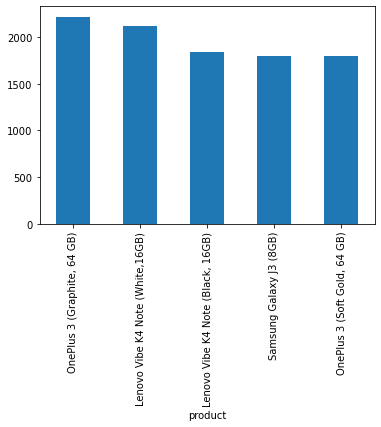

In [293]:
#df_2.groupby(by=['product'])['score'].value_counts()
r1 = df_2.groupby(by=['product'])['score'].size().sort_values(ascending=False).head(5)
#df_2.groupby(by=['product','score']).size().sort_values(ascending=False).head(5)
#df_2[df_2['product'] == 'Lenovo Vibe K4 Note (White,16GB)'].head(10)
print(r1)
r1.plot(kind='bar')

product                                 score
OnePlus 3 (Graphite, 64 GB)             10       1572
OnePlus 3 (Soft Gold, 64 GB)            10       1191
Samsung Galaxy S7 edge 32GB (Verizon)   10       1129
Samsung Galaxy S7 edge 32GB (T-Mobile)  10       1118
Samsung Galaxy J3 (8GB)                 10       1104
dtype: int64


<AxesSubplot:xlabel='product,score'>

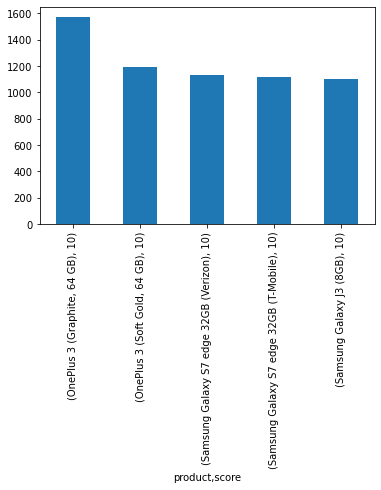

In [294]:
#df_2.groupby(by=['product'])['score'].value_counts()
#r1 = df_2.groupby(by=['product'])['score'].size().sort_values(ascending=False).head(5)
#df_2.groupby(by=['product','score']).size().sort_values(ascending=False).head(5)
#df_2[df_2['product'] == 'Lenovo Vibe K4 Note (White,16GB)'].head(10)
r1 = df_2.groupby(by=['product','score']).size().sort_values(ascending=False).head(5)
print(r1)
r1.plot(kind='bar')

### <font color=darkorange> Identify the users with most number of reviews.


author
Amazon Customer    16833
Annonymous         12915
Cliente Amazon      6385
Client d'Amazon     2697
Amazon Kunde        2022
dtype: int64


<AxesSubplot:>

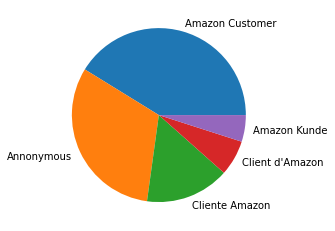

In [295]:
r2 = df_2.groupby(by=['author']).size().sort_values(ascending=False).head(5)
print(r2)
r2.plot(ylabel='',kind='pie')

### <font color=darkorange> Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset

In [296]:
cutOffValue = 50
#df_2.groupby(by=['product'])['score'].size().sort_values(ascending=False).head(5)
g1 = df_2.groupby(by=['product'])['score'].size().sort_values(ascending=False)[lambda x: (x > cutOffValue)]
g2 = df_2.groupby(by=['author'])['score'].size().sort_values(ascending=False)[lambda x: (x > cutOffValue)]
print(len(g1), " ", len(g2))
print(type(g1), " ", type(g2))
products = g1.reset_index()['product']
authors = g2.reset_index()['author']
df_3 = df_2[(df_2['product'].isin(products) & df_2['author'].isin(authors))]
print(f"Final Dataset shape is {df_3.shape}")
df_3.sample(5)

5788   860
<class 'pandas.core.series.Series'>   <class 'pandas.core.series.Series'>
Final Dataset shape is (73592, 3)


,score,author,product
25381,2,Robert,Samsung Galaxy S7 SM-G930F 32GB Smartphone (Un...
89581,4,Daniel,"HTC Desire C Smartphone (8,9 cm (3,5 Zoll) HVG..."
68160,4,Simone,HTC Wildfire S Smartphone (8.1 cm (3.2 Zoll) T...
179826,8,anonym,LG GT540
282578,8,Amazon Customer,LG G4 H815 32GB Unlocked GSM Hexa-Core Android...


In [297]:
# Number of product and author count in each rating
r3 = pd.DataFrame(df_3.groupby('score').count())
r3

,author,product
score,,
1,82,82
2,7915,7915
3,170,170
4,4968,4968
5,315,315
6,7038,7038
7,704,704
8,17436,17436
9,2671,2671


## <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.2em;color:#00b3e5;"> RS - Excercise

### <font color=darkorange> Build a popularity based model and recommend top 5 mobile phones

In [298]:
#pop_based_recommendation = pd.DataFrame(df_3.groupby('product')['score'].mean())
#pop_based_recommendation = pd.DataFrame(df_3.groupby('score') 
#pop_based_recommendation.head(5)

In [299]:
pop_based_recommendation = pd.DataFrame(df_3.groupby('product')['score'].count())
pop_based_recommendation.sort_values(by=['score'], ascending=False, inplace=True)
r4 = pop_based_recommendation.head(5)
print(r4)

                                                    score
product                                                  
Huawei P8 Lite Smartphone, Display 5" IPS, Proc...    222
Apple iPhone 5s 16GB (ÑÐµÑÐµÐ±ÑÐ¸ÑÑÑÐ¹)         209
Lenovo Motorola Moto G Smartphone, 4,5 pollici ...    200
Huawei P8lite zwart / 16 GB                           199
Huawei P9 Lite Smartphone, LTE, Display 5.2'' F...    196


### <font color=darkorange> Build a collaborative filtering model using SVD. You can use SVD from surprise or build it from scratch(Note: Incase you’re building it from scratch you can limit your data points to 5000 samples if you face memory issues). Build a collaborative filtering model using kNNWithMeans from surprise. You can try both user-based and item-based model. 

In [300]:
from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [301]:
df_4 = df_3.rename(columns = {'score':'rating', 'product':'itemID','author':'userID'})
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73592 entries, 253 to 163671
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  73592 non-null  int8  
 1   userID  73592 non-null  object
 2   itemID  73592 non-null  object
dtypes: int8(1), object(2)
memory usage: 1.8+ MB


In [302]:
reader = Reader(rating_scale=(1, 10))

In [303]:
rs_df = df_4[['userID', 'itemID', 'rating']].sample(n=len(df_4), random_state=723)
rs_df.head()

,userID,itemID,rating
185072,ÐÐ°ÑÐ¸Ð½Ð°,Sony Xperia Z (ÑÐµÑÐ½ÑÐ¹),6
106881,Amazon Kunde,"Microsoft Lumia 550 Smartphone (4,7 Zoll (11,9...",2
70559,Annonymous,Nokia Asha 303,4
88148,Customer,Samsung Galaxy S5 Mini G800H Unlocked Cellphon...,10
72729,Anthony,Samsung Galaxy Reverb (Virgin Mobile),10


In [304]:
rs_df.shape

(73592, 3)

In [305]:
# For recommendation system we need all the feature to be represented
# as number
rs_df['userName'] = rs_df['userID']
rs_df['itemName'] = rs_df['itemID']

rs_df['userID'] = rs_df.userID.astype('category')
rs_df['userID'] = rs_df['userID'].cat.codes
rs_df['userID'] = rs_df.userID.astype('int16')

rs_df['itemID'] = rs_df.itemID.astype('category')
rs_df['itemID'] = rs_df['itemID'].cat.codes
rs_df['itemID'] = rs_df.itemID.astype('int16')

rs_df_org = rs_df.copy()
rs_df.drop(columns=['userName','itemName'],inplace=True)
rs_df_org.head()


,userID,itemID,rating,userName,itemName
185072,832,5154,6,ÐÐ°ÑÐ¸Ð½Ð°,Sony Xperia Z (ÑÐµÑÐ½ÑÐ¹)
106881,56,2159,2,Amazon Kunde,"Microsoft Lumia 550 Smartphone (4,7 Zoll (11,9..."
70559,84,2931,4,Annonymous,Nokia Asha 303
88148,145,4148,10,Customer,Samsung Galaxy S5 Mini G800H Unlocked Cellphon...
72729,90,3898,10,Anthony,Samsung Galaxy Reverb (Virgin Mobile)


In [306]:
#rs_df.loc[(rs_df['userID'] == 323) & (rs_df['itemID'] == 1362)]

In [307]:
rs_df_org.loc[(rs_df['itemID'] == 1119)]

,userID,itemID,rating,userName,itemName
346198,84,1119,6,Annonymous,HTC Touch Cruise
346091,129,1119,9,Chris,HTC Touch Cruise
346113,84,1119,10,Annonymous,HTC Touch Cruise
346163,690,1119,6,manuel,HTC Touch Cruise
346124,84,1119,8,Annonymous,HTC Touch Cruise


In [308]:
data = Dataset.load_from_df(rs_df, reader)
print(data.build_full_trainset)

<bound method DatasetAutoFolds.build_full_trainset of <surprise.dataset.DatasetAutoFolds object at 0x000001D76F09E970>>


In [309]:
trainset, testset = train_test_split(data, test_size=.15)

In [310]:
algo_svd = SVD()
algo_svd.fit(trainset)
svd_predictions = algo_svd.test(testset)

In [311]:
svd_predictions

[Prediction(uid=140, iid=5029, r_ui=10.0, est=5.009828832635761, details={'was_impossible': False}),
 Prediction(uid=8, iid=5103, r_ui=10.0, est=6.689151194406438, details={'was_impossible': False}),
 Prediction(uid=157, iid=1133, r_ui=10.0, est=7.519876309231556, details={'was_impossible': False}),
 Prediction(uid=137, iid=2281, r_ui=4.0, est=8.482591643697514, details={'was_impossible': False}),
 Prediction(uid=84, iid=2985, r_ui=6.0, est=6.087854604786534, details={'was_impossible': False}),
 Prediction(uid=102, iid=1804, r_ui=2.0, est=7.938837070428164, details={'was_impossible': False}),
 Prediction(uid=600, iid=2774, r_ui=6.0, est=8.071730899150902, details={'was_impossible': False}),
 Prediction(uid=498, iid=4315, r_ui=10.0, est=8.198594624080444, details={'was_impossible': False}),
 Prediction(uid=849, iid=4255, r_ui=10.0, est=9.389902822930093, details={'was_impossible': False}),
 Prediction(uid=788, iid=3597, r_ui=10.0, est=9.670473118103594, details={'was_impossible': False}

In [312]:
algo_knn = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_knn.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [313]:
pred = algo_knn.predict(73, 1122, verbose=True)

user: 73         item: 1122       r_ui = None   est = 7.56   {'actual_k': 2, 'was_impossible': False}


In [314]:
test_pred = algo_knn.test(testset)

In [315]:
test_pred

[Prediction(uid=140, iid=5029, r_ui=10.0, est=5.0, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=8, iid=5103, r_ui=10.0, est=4.074469628095848, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid=157, iid=1133, r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=137, iid=2281, r_ui=4.0, est=10, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=84, iid=2985, r_ui=6.0, est=5.987412226690581, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid=102, iid=1804, r_ui=2.0, est=7.948442713940596, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=600, iid=2774, r_ui=6.0, est=7.9892334177003725, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=498, iid=4315, r_ui=10.0, est=8.5848322121807, details={'actual_k': 12, 'was_impossible': False}),
 Prediction(uid=849, iid=4255, r_ui=10.0, est=9.810286660444753, details={'actual_k': 18, 'was_impossible': False}),
 Predi

In [316]:
algo_ib = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_ib.fit(trainset)
pred = algo_ib.predict(73, 1661, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
user: 73         item: 1661       r_ui = None   est = 10.00   {'actual_k': 0, 'was_impossible': False}


In [317]:
test_pred_ib = algo_ib.test(testset)
test_pred_ib

[Prediction(uid=140, iid=5029, r_ui=10.0, est=4.7882624946991585, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid=8, iid=5103, r_ui=10.0, est=4.368439499063234, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=157, iid=1133, r_ui=10.0, est=7.0900952521970435, details={'actual_k': 24, 'was_impossible': False}),
 Prediction(uid=137, iid=2281, r_ui=4.0, est=9.017153467214818, details={'actual_k': 24, 'was_impossible': False}),
 Prediction(uid=84, iid=2985, r_ui=6.0, est=5.939302353931136, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid=102, iid=1804, r_ui=2.0, est=7.878736654585501, details={'actual_k': 45, 'was_impossible': False}),
 Prediction(uid=600, iid=2774, r_ui=6.0, est=8.122102343352385, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid=498, iid=4315, r_ui=10.0, est=8.339593848488784, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid=849, iid=4255, r_ui=10.0, est=9.576205618917037, deta

### <font color=darkorange> Evaluate the collaborative model. Print RMSE value. 


In [318]:
print("SVD Model : Test Set")
accuracy.rmse(svd_predictions, verbose=True)
print("")
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)
print("")
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_ib, verbose=True)

SVD Model : Test Set
RMSE: 2.8535

User-based Model : Test Set
RMSE: 3.1032

Item-based Model : Test Set
RMSE: 2.9731


2.973059946586891

### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> SVD Model gives lowest RMSE value but almost all of them are close.

### <font color=darkorange> Predict score (average rating) for test users.  


In [319]:
def print_predict_score(prediction):
    score = 0.0
    count = 0
    for pred in prediction:
        score = score + pred.est
        count = count + 1
    print(f"Score is {score} and count is {count}")
    print(f"Average is {score/count:.{4}}")

In [320]:
print_predict_score(svd_predictions)

Score is 85333.35677804054 and count is 11039
Average is 7.73


In [321]:
print_predict_score(test_pred)

Score is 85217.95603271859 and count is 11039
Average is 7.72


In [322]:
print_predict_score(test_pred_ib)

Score is 84504.07909878601 and count is 11039
Average is 7.655


### <font color=darkorange> Report your findings and inferences.  


### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> <li>The RMSE between User based Collabrative System and Item based collabrative system shows. The SVD model gives the lowest RMSE</li><li>The product "OnePlus 3 (Graphite, 64 GB)" was reviewed by lot of users and got highest rating 10 from many people as well</li><li>Among users participated in review process - Amazon Customer top the list with maximum reviews</li>

### <font color=darkorange> Try and recommend top 5 products for test users. 


In [323]:
products = []
new_df = pd.DataFrame(columns=['userID','itemID', 'rating'])
for pred in svd_predictions:
    #print(pred.uid, pred.iid, pred.est)
    new_df = new_df.append({'userID':pred.uid, 'itemID':pred.iid, 'rating':pred.est},ignore_index=True)
    count = count + 1
new_df.sort_values(by=['rating'], ascending=False, inplace=True, ignore_index=True)
#new_df = pd.DataFrame(new_df.groupby('itemID', as_index=False)['rating'].mean()) 
new_df_rs = new_df.head(5)
display(new_df_rs)
print_inference("Following are the product from SVD Prediction test User:", None)
for df_index in new_df_rs.index:
    uid = new_df_rs['userID'][df_index]
    iid = new_df_rs['itemID'][df_index]
    rating = new_df_rs['rating'][df_index]
    S = rs_df_org.loc[(rs_df_org['itemID'] == iid) & (rs_df_org['userID'] == uid)]
    print_inference(S.reset_index()['itemName'][0], None)
    #S.decode('ascii','strict')
    
    #df.loc[df['column_name'] == some_value]

#rs_df.loc[(rs_df['userID'] == 323) & (rs_df['itemID'] == 1362)]

,userID,itemID,rating
0,483.0,1172.0,10.0
1,396.0,4714.0,10.0
2,129.0,2387.0,10.0
3,120.0,2001.0,10.0
4,444.0,408.0,10.0


#### [Following are the product from SVD Prediction test User:]

#### [Honor 6 - Smartphone libre (pantalla de 5", 16GB, 3 GB de RAM, cÃ¡mara trasera de 13 MP y delantera de 5 MP, Android OS, v4.4.2 KitKat, LTE) blanco]

#### [Sim Free Apple iPhone 5S 16GB Mobile Phone - Space Grey]

#### [Motorola Droid RAZR HD XT926 Verizon Wireless, 16GB, Black]

#### [Lenovo Moto G4 Play - Smartphone de 5 (4G, RAM de 2 GB, memoria interna de 16 GB, cÃ¡mara de 8 MP, Android 6), blanco]

#### [Asus ZenFone 3 Smartphone, Display da 5.2", Memoria Interna da 64 GB, 4 GB RAM, Dual-SIM, Nero [Italia]]

### <font color=darkorange> Try other techniques (Example: cross validation) to get better results.  

In [324]:
cross_validate(algo_svd, data, measures=['RMSE'], cv=5, verbose=True)
cross_validate(algo_knn, data, measures=['RMSE'], cv=5, verbose=True)
cross_validate(algo_ib, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.8636  2.8545  2.8345  2.8876  2.8771  2.8634  0.0184  
Fit time          3.36    3.33    3.27    2.74    2.72    3.08    0.29    
Test time         0.22    0.18    0.09    0.08    0.08    0.13    0.06    
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

        

{'test_rmse': array([3.01542841, 2.96537926, 2.97886041, 2.99910814, 2.99563812]),
 'fit_time': (15.167779445648193,
  14.074241876602173,
  15.39452338218689,
  13.256855249404907,
  10.438141822814941),
 'test_time': (14.053057432174683,
  12.85249924659729,
  13.6318039894104,
  14.763254880905151,
  13.320458889007568)}

### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> The Mean of SVD Prediction is comes lower with CV = 5

### <font color=darkorange> In what business scenario you should use popularity based Recommendation Systems ?  


### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> Popularity based recommendation system works by recommending items viewed/purchased by most people and rated high (or in trending) </span>
### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> Useful when there is no prior knowledge about user and their like and disliking. We can recommend popular Item to any new user signing in.

### <font color=darkorange> In what business scenario you should use CF based Recommendation Systems ?  


### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> Collabrative Filtering uses historical data to predict the future usage/need. There are two types,</span>
#### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> <li>User based Collabrative Filtering</li><li>Item based collabrative filtering</li></span>
### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> The User based CF uses historical data between users of similar interest and suggest product. The Item based CF will be using similar item rated by users and uses the item similarity for future recommendation</span>
### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> These CF is a idle usecase where we can use them when we have user and item purchase history and interest</span>

### <font color=darkorange> What other possible methods can you think of which can further improve the recommendation for different users ?

### <span style="font-family: Trebuchet MS; font-weight:bold;font-size:0.9em;color:darkblue;"> Other types of possible recommendation systems are Content Based Recommendation System, Classification Model, Association Rule mining, etc. There are hybrid approaches available where we can club popularity based RS and Item based RS to get better recommendation for users.

 # <span style="font-family: Trebuchet MS; font-weight:bold;font-size:1.5em;color:#00b3e5;">  End of Recommendation System Project
